In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False


# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [2]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [8]:

import os
image_raw = tf.io.read_file(os.path.join('data', 'ardilla.jpg'))
image = tf.image.decode_image(image_raw)
image = tf.cast(image, tf.float32)
image = tf.image.resize(image, (224, 224))
image = image[None, ...]
if image.shape[-1] == 4:
    image = image[..., :3]

image = tf.keras.applications.mobilenet_v2.preprocess_input(image)


image_probs = pretrained_model.predict(image)


1/1 [==============================] - 5s 5s/step


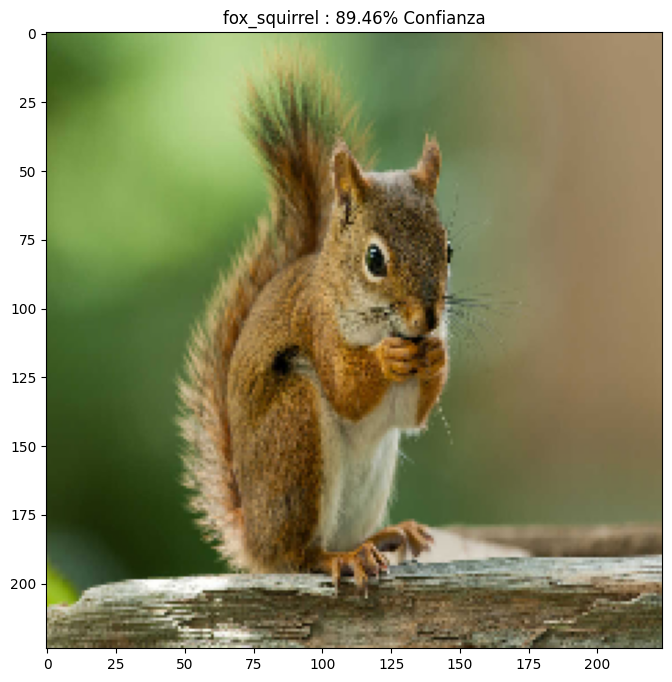

In [24]:
plt.figure()
plt.imshow((image[0] * 0.5 + 0.5))  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confianza'.format(image_class, class_confidence*100))
plt.show()

In [35]:
# Creamos el objeto de perdida
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  # Obtenemos el gradiente de la imagen con respecto a la etiqueta
  with tf.GradientTape() as tape:
    # Aseguramos que la variable input_image es rastreada
    tape.watch(input_image)
    # Obtenemos la prediccion del modelo con respecto a la imagen
    prediction = pretrained_model(input_image)
    # Obtenemos la perdida de la prediccion
    loss = loss_object(input_label, prediction)

  # Obtenemos el gradiente de la perdida con respecto a la imagen
  gradient = tape.gradient(loss, input_image)
  # Regresamos el signo del gradiente
  signed_grad = tf.sign(gradient)
  return signed_grad

In [26]:
fox_squirrel = 335

image_probs

array([[1.30705375e-04, 5.22685114e-05, 3.42745734e-05, 9.22205254e-06,
        1.39915064e-05, 8.72565724e-05, 3.44710570e-05, 9.08585571e-05,
        5.58819193e-05, 7.44109129e-05, 9.33268981e-04, 2.01896735e-04,
        1.56199501e-04, 6.54576928e-04, 1.38025542e-04, 3.87035689e-04,
        8.00281559e-05, 1.05961750e-04, 4.22087287e-05, 1.26506391e-04,
        1.34278584e-04, 2.29864472e-05, 6.85513951e-05, 3.44477885e-05,
        8.12729850e-05, 5.06412034e-05, 3.16959107e-04, 3.05345806e-04,
        1.29698718e-04, 2.17930690e-04, 3.08718067e-04, 1.63970501e-04,
        4.96090041e-04, 3.58597863e-05, 4.06912695e-05, 3.58847574e-05,
        6.20503852e-05, 7.26703438e-05, 1.25740335e-04, 1.90938634e-04,
        8.29354103e-05, 5.03033953e-05, 1.68921077e-04, 1.03086699e-04,
        3.25327783e-05, 4.53873363e-05, 1.35897033e-04, 3.79448975e-05,
        1.60965246e-05, 1.71225009e-04, 2.43140239e-05, 3.74394258e-05,
        4.83907024e-05, 2.91878223e-05, 7.82895004e-05, 4.124610

In [27]:
image_probs.shape

(1, 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


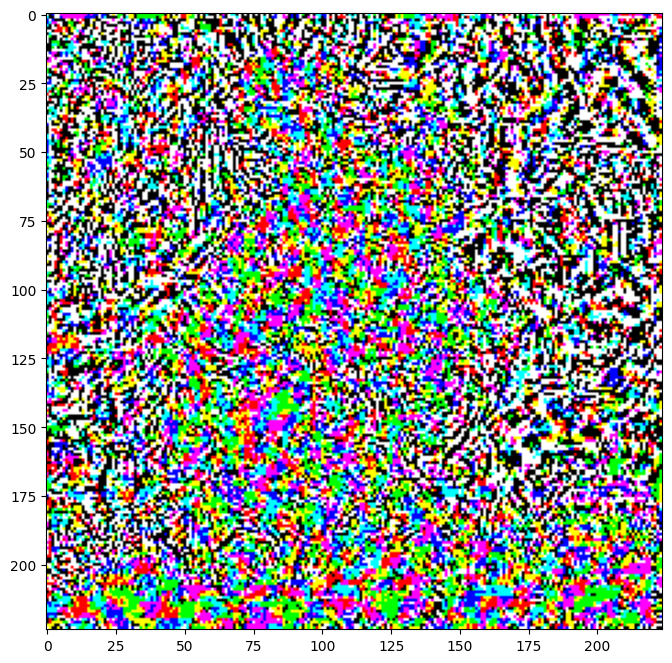

In [31]:
# Get the input label of the image.
label = tf.one_hot(fox_squirrel, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0]);  # To change [-1, 1] to [0,1]

In [39]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0] * 0.5 + 0.5)
  plt.title('{} \n {} : {:.2f}% Confianza'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 [==============================] - 0s 25ms/step


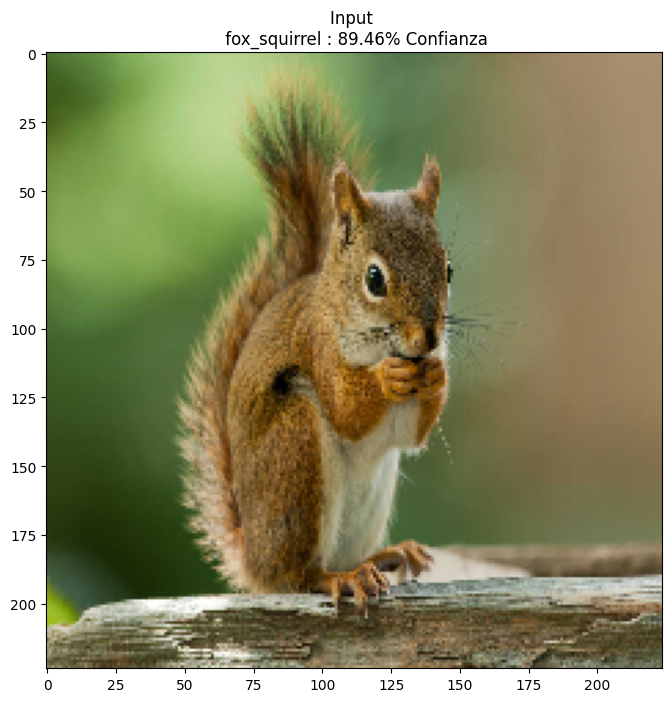

1/1 [==============================] - 0s 25ms/step


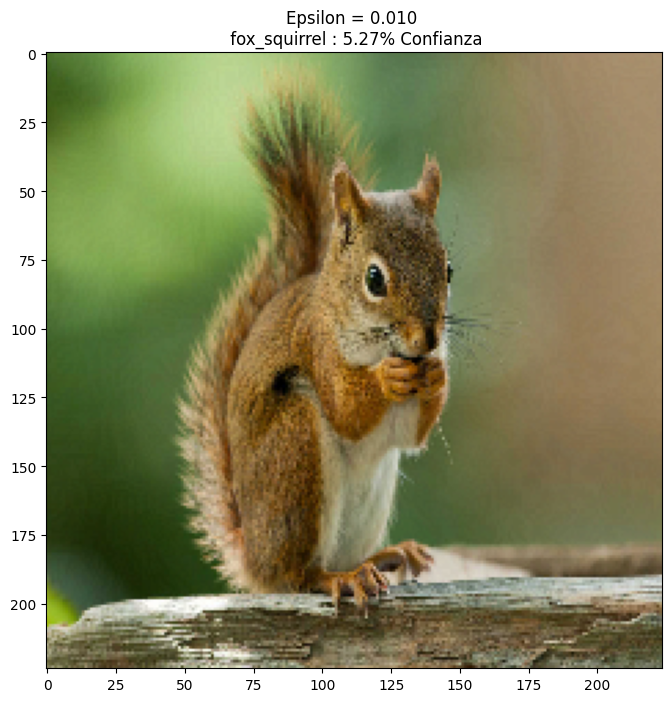

1/1 [==============================] - 0s 23ms/step


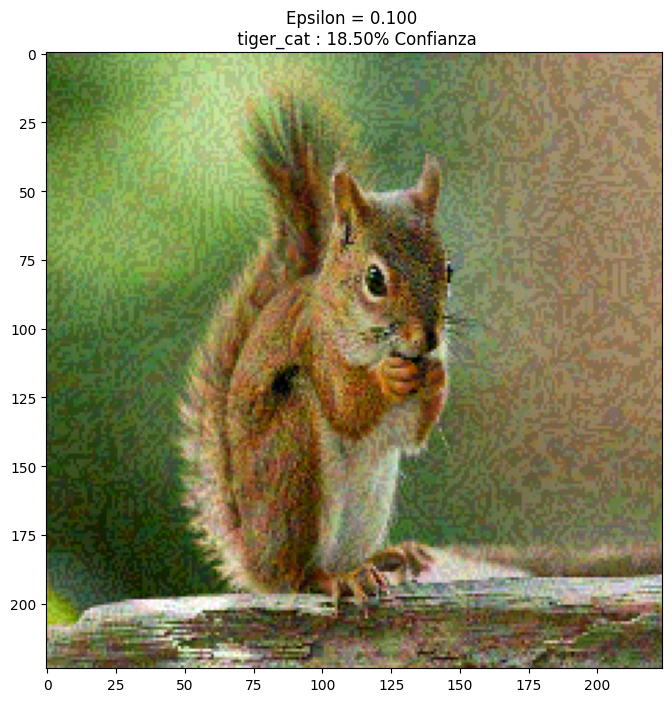

1/1 [==============================] - 0s 29ms/step


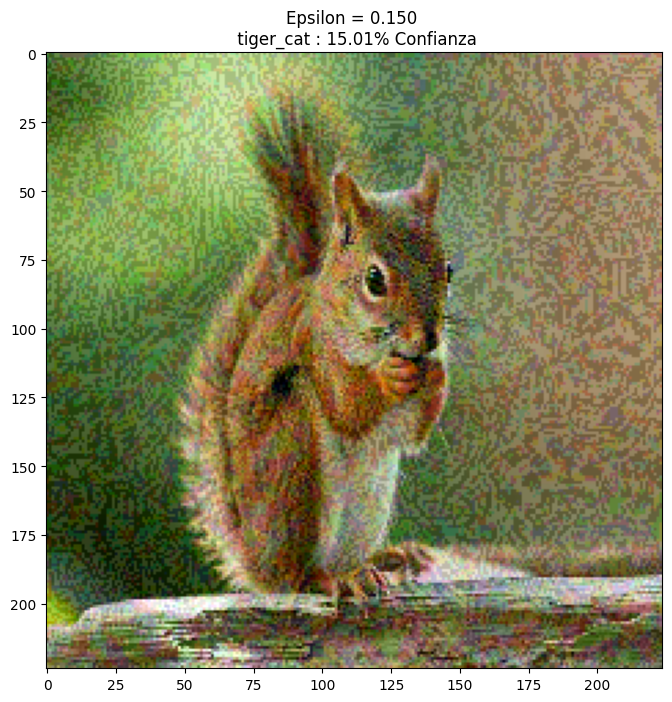

1/1 [==============================] - 0s 53ms/step


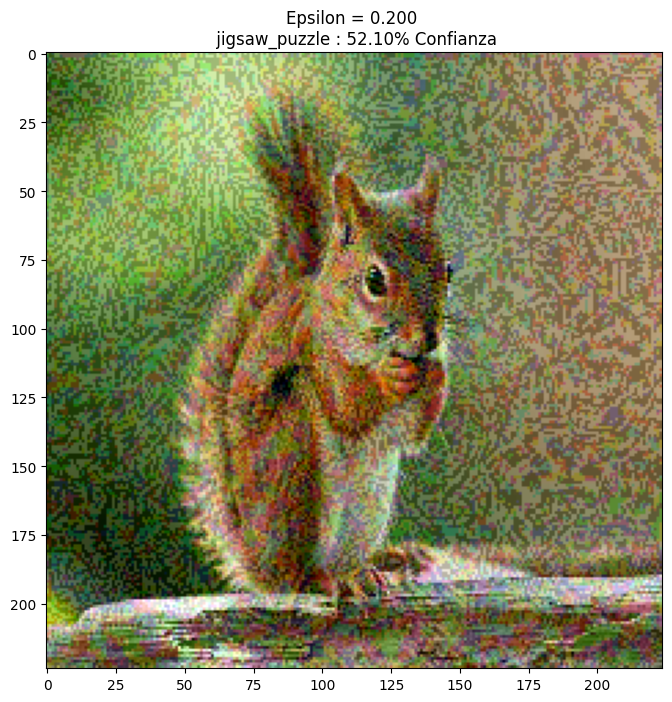

1/1 [==============================] - 0s 28ms/step


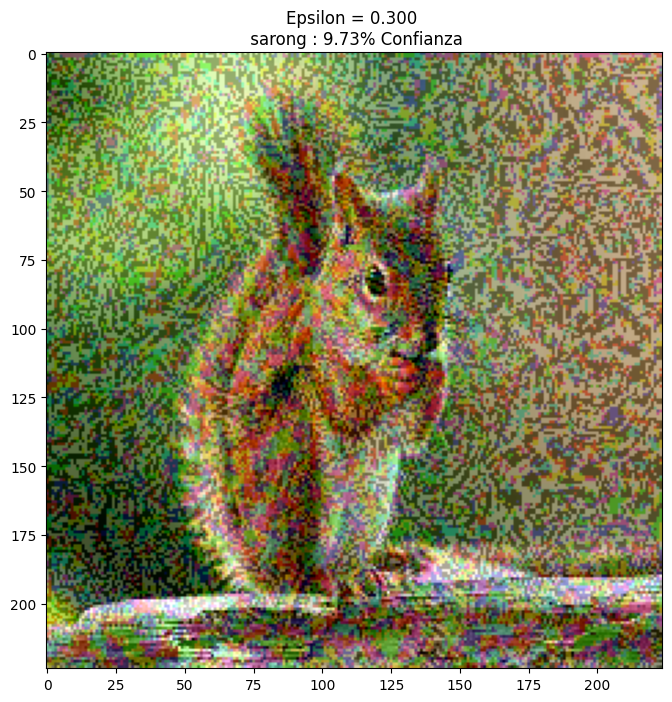

In [40]:
epsilons = [0, 0.01, 0.1, 0.15, 0.2, 0.3]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  # Se crea la imagen adversarial a partir de la imagen original, la perturbacion y el valor de epsilon
  adv_x = image + eps * perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])